In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend
from statsmodels.regression.linear_model import OLS
from scipy.signal import periodogram

## Loading data

,Year,Month,Day,Temperature
Date,,,,
1756-01-01,1756,1,1,-8.7
1756-01-02,1756,1,2,-9.2
1756-01-03,1756,1,3,-8.6
1756-01-04,1756,1,4,-7.7
1756-01-05,1756,1,5,-7.2
...,...,...,...,...
2017-12-27,2017,12,27,2.5
2017-12-28,2017,12,28,3.8
2017-12-29,2017,12,29,2.4


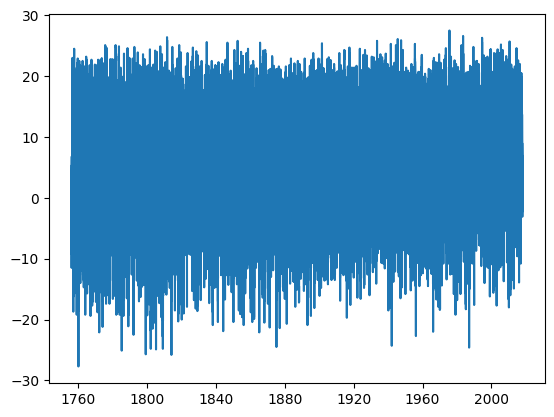

In [2]:
data=pd.read_csv("stockholm_daily_mean_temperature_1756_2017.txt",sep="\s+",header=None,usecols=[0,1,2,5],names=["Year","Month","Day","Temperature"])
data["Date"]=pd.to_datetime(data[["Year","Month","Day"]])
data.set_index("Date",inplace=True)
display(data)
plt.plot(data.index,data["Temperature"])
plt.show()


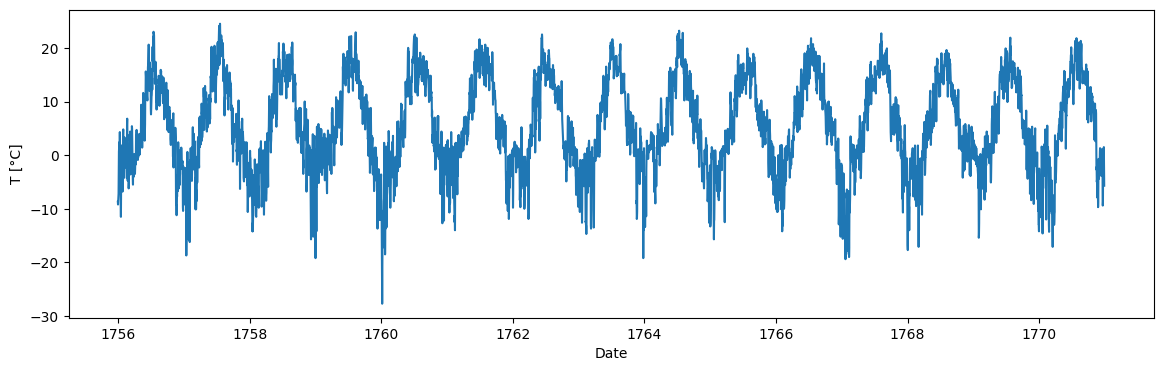

In [3]:
#Zooming in looking for periodicty
first_samples=data.head(365*15)
fig=plt.figure(figsize=(14,4))
plt.plot(first_samples.index,first_samples["Temperature"])
plt.xlabel("Date")
plt.ylabel(r"T [°C]")
plt.savefig("A_series")
plt.show()

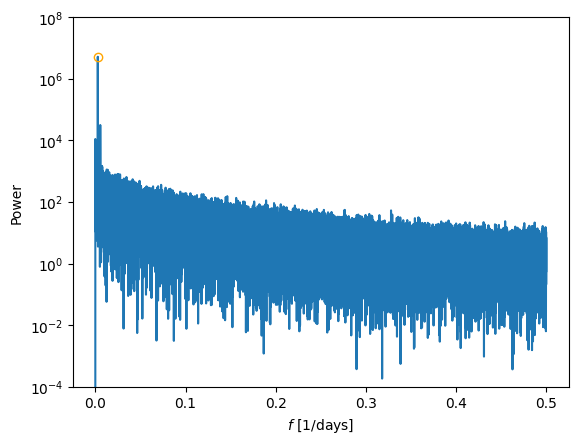

The peak is at 0.0027378937028444835 which corresponds to a period of 365.2442748091603 days.


In [4]:

f, px =periodogram(data["Temperature"])
plt.plot(f,px)
plt.yscale("log")
plt.ylim([1E-4,1E8])
max_p=np.max(px)
max_f=f[np.argmax(px)]
plt.plot(max_f,max_p,'o',markerfacecolor='none',markeredgecolor='orange')
plt.ylabel("Power")
plt.xlabel(r"$f$ [1/days]")
plt.show()
print("The peak is at",max_f,"which corresponds to a period of",1/max_f,"days.")


## Cleaning the data

0.004533462821696865
5.2211762363434


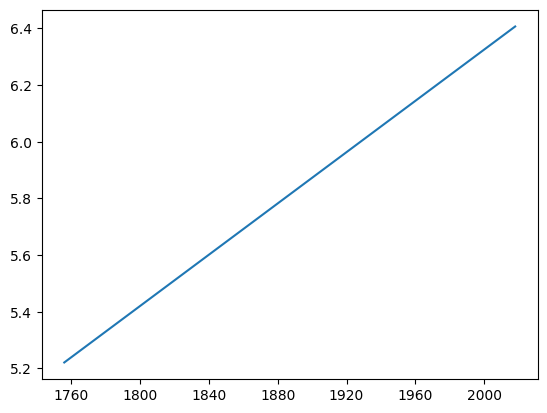

In [5]:
#Removing linear trend
data_detrended=detrend(data["Temperature"],order=1)
#We can see the linear model by
trend=data["Temperature"]-data_detrended
trend_coefficient = trend["1757-1-1"] -  trend["1756-1-1"]
trend_const = trend.iloc[0]
print(trend_coefficient)
print(trend_const)
plt.plot(trend.index,trend)
plt.show()

In [6]:
seas_decompose_4_years=seasonal_decompose(data_detrended,period=365*4+1,filt=np.zeros(1000),extrapolate_trend=1)
seas_decompose_1_year=seasonal_decompose(data_detrended,period=365,filt=np.zeros(1000),extrapolate_trend=1)

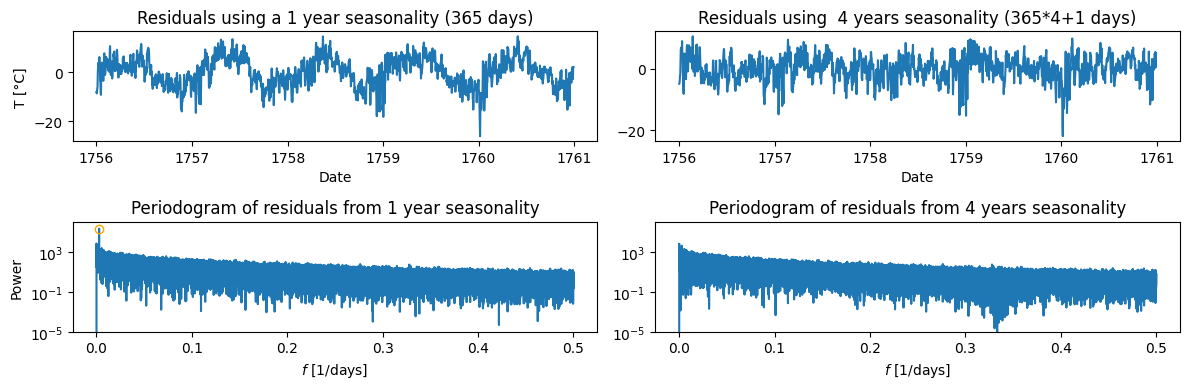

In [7]:
fig,axs=plt.subplots(2,2,figsize=(12,4))
axs[0,0].plot(seas_decompose_1_year.resid.head(365*5).index,seas_decompose_1_year.resid.head(365*5))
axs[0,0].set_title("Residuals using a 1 year seasonality (365 days)")
axs[0,0].set_ylabel(r"T [°C]")
axs[0,0].set_xlabel(r"Date")
axs[0,1].plot(seas_decompose_4_years.resid.head(365*5).index,seas_decompose_4_years.resid.head(365*5))
axs[0,1].set_title("Residuals using  4 years seasonality (365*4+1 days)")
axs[0,1].set_xlabel(r"Date")
f, px =periodogram(seas_decompose_1_year.resid)
axs[1,0].plot(f,px)
axs[1,0].set_title("Periodogram of residuals from 1 year seasonality")
axs[1,0].set_yscale("log")
axs[1,0].set_ylim([1E-5,1E6])
max_p=np.max(px)
max_f=f[np.argmax(px)]
axs[1,0].plot(max_f,max_p,'o',markerfacecolor='none',markeredgecolor='orange')
axs[1,0].set_ylabel("Power")
axs[1,0].set_xlabel(r"$f$ [1/days]")
f, px =periodogram(seas_decompose_4_years.resid)
axs[1,1].plot(f,px)
axs[1,1].set_title("Periodogram of residuals from 4 years seasonality")
axs[1,1].set_yscale("log")
axs[1,1].set_ylim([1E-5,1E6])
axs[1,1].set_xlabel(r"$f$ [1/days]")
fig.tight_layout()
plt.savefig("A_periods")
plt.show()

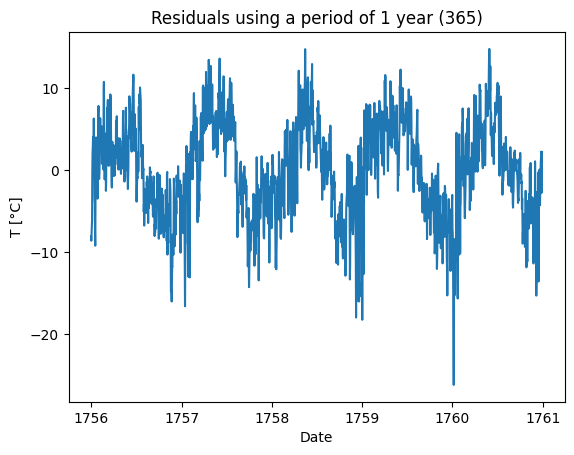

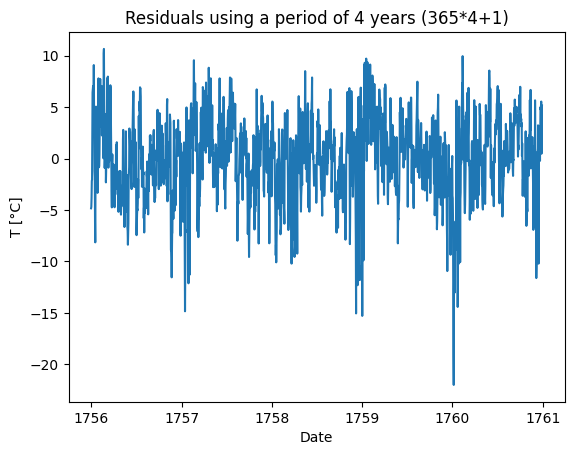

In [8]:
plt.plot(seas_decompose_1_year.resid.head(365*5).index,seas_decompose_1_year.resid.head(365*5))
plt.title("Residuals using a period of 1 year (365)")
plt.xlabel("Date")
plt.ylabel(r"T [°C]")
plt.show()
plt.plot(seas_decompose_4_years.resid.head(365*5).index,seas_decompose_4_years.resid.head(365*5))
plt.title("Residuals using a period of 4 years (365*4+1)")
plt.xlabel("Date")
plt.ylabel(r"T [°C]")
plt.show()

363.8555133079848


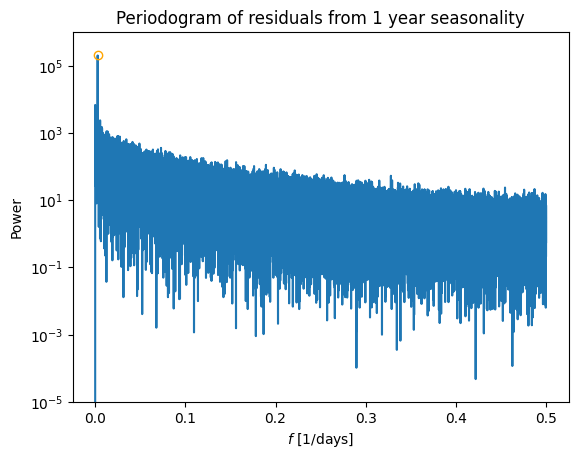

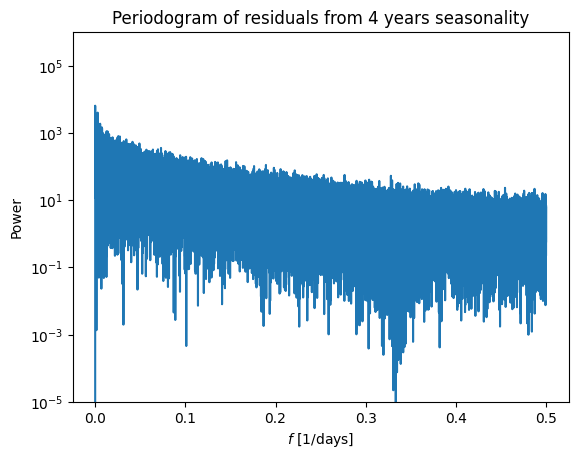

In [9]:
f, px =periodogram(seas_decompose_1_year.resid)
plt.plot(f,px)
plt.title("Periodogram of residuals from 1 year seasonality")
plt.yscale("log")
plt.ylim([1E-5,1E6])
max_p=np.max(px)
max_f=f[np.argmax(px)]
print(1/max_f)
plt.plot(max_f,max_p,'o',markerfacecolor='none',markeredgecolor='orange')
plt.ylabel("Power")
plt.xlabel(r"$f$ [1/days]")
plt.show()
f, px =periodogram(seas_decompose_4_years.resid)
plt.plot(f,px)
plt.title("Periodogram of residuals from 4 years seasonality")
plt.yscale("log")
plt.ylim([1E-5,1E6])
plt.ylabel("Power")
plt.xlabel(r"$f$ [1/days]")
plt.show()

In [10]:
data_cleaned=seas_decompose_4_years.resid

## Fitting ARMA Models

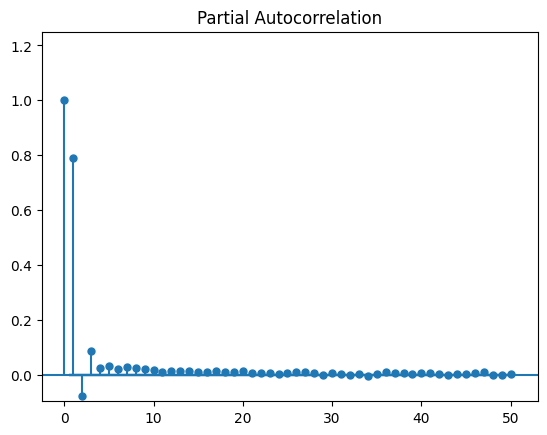

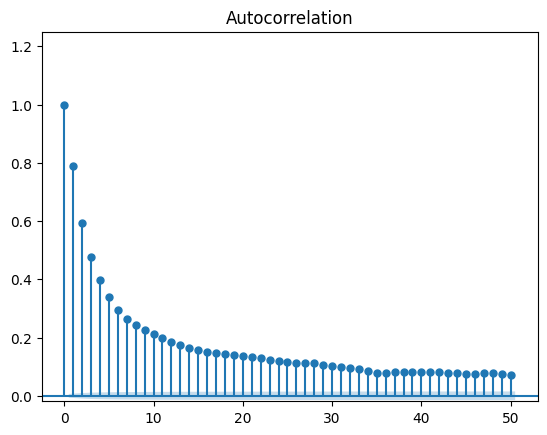

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#from pmdarima import auto_arima

##Plot the acf and pacf to determine the order
_=plot_pacf(data_cleaned, alpha = 0.05, auto_ylims = True)
_=plot_acf(data_cleaned, alpha = 0.05, auto_ylims= True)
##The ACF decays geometrically, indicating that an ARMA model is suitable for fitting

In [16]:
maxp=3
maxq=5

aiccs=np.zeros((maxp+1,maxq+1)) 
aics=np.zeros((maxp+1,maxq+1)) 
bics=np.zeros((maxp+1,maxq+1)) 

for p in range(0,maxp+1):
  for q in range(0,maxq+1):
    model = ARIMA(data_cleaned, order=(p, 0 ,q)).fit(method= "innovations_mle")
    
    aiccs[p,q]=model.aicc
    aics[p,q]=model.aic
    bics[p,q]=model.bic

'''
ind = np.argmin(aiccs)
model = ARIMA(data_cleaned, order= orders[ind]).fit(method= "innovations_mle")
print(aiccs)
print(orders)
print(orders[ind])
'''

c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\s

'\nind = np.argmin(aiccs)\nmodel = ARIMA(data_cleaned, order= orders[ind]).fit(method= "innovations_mle")\nprint(aiccs)\nprint(orders)\nprint(orders[ind])\n'

In [17]:
print(aiccs)
print(aics)
print(bics)

[[523351.92284316 462141.1299214  443902.53604167 436884.49625021
  433752.91815148 431927.53831634]
 [430191.85544694 429484.33596239 428889.02015596 428716.41869521
  428590.22745278 428507.20328175]
 [429630.31145459 429186.07433887 428343.1018601  428254.75583228
  428250.45011756 428250.60584819]
 [428869.70437322 428495.4494437  428272.05081587 428249.0673179
  428247.18429978 428252.19703564]]
[[523351.92271776 462141.12967059 443902.53562364 436884.49562318
  433752.91727362 431927.53714584]
 [430191.85519613 429484.33554437 428889.01952893 428716.41781735
  428590.22628229 428507.20177681]
 [429630.31103657 429186.07371183 428343.10098224 428254.75466178
  428250.44861262 428250.603967  ]
 [428869.70374618 428495.44856584 428272.04964537 428249.06581296
  428247.18241859 428252.19473638]]
[[523370.86053952 462169.53640323 443940.41126716 436931.84017757
  433809.7307389  431993.819522  ]
 [430220.26192877 429522.21118789 428936.36408332 428773.23128262
  428656.50865844 428582

In [18]:
for q in range(maxq):
    print("$q=",q,"$&",end="")
print("$q=",maxq,"$\\\\")
for p in range(maxp+1):
    print("$p=",p,"$&",end="")
    for q in range(maxq):
        print("{:.2f}".format(aiccs[p,q]),"&",end="")
    print("{:.2f}".format(aiccs[p,maxq]),"\\\\")

$q= 0 $&$q= 1 $&$q= 2 $&$q= 3 $&$q= 4 $&$q= 5 $\\
$q= 0 $&523351.92 &462141.13 &443902.54 &436884.50 &433752.92 &431927.54 \\
$q= 1 $&430191.86 &429484.34 &428889.02 &428716.42 &428590.23 &428507.20 \\
$q= 2 $&429630.31 &429186.07 &428343.10 &428254.76 &428250.45 &428250.61 \\
$q= 3 $&428869.70 &428495.45 &428272.05 &428249.07 &428247.18 &428252.20 \\


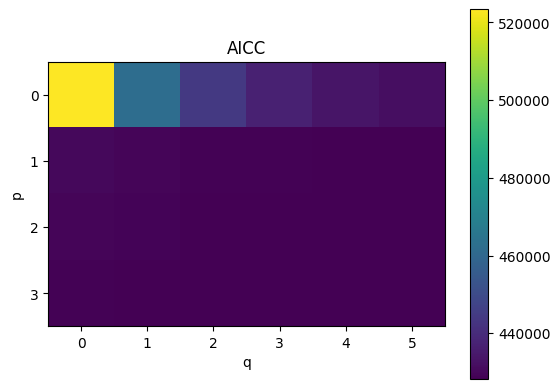

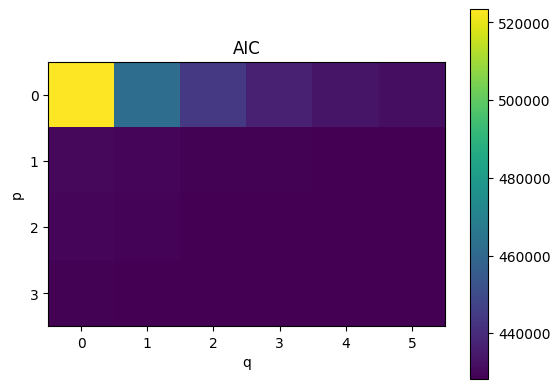

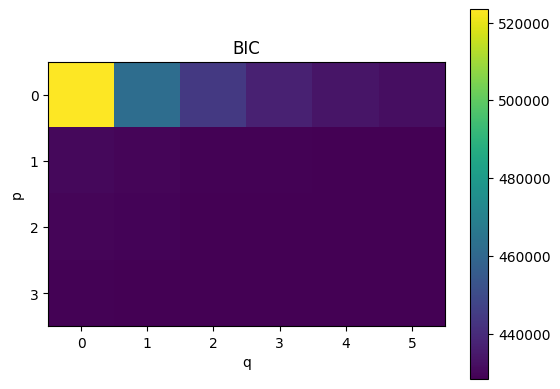

In [19]:
plt.imshow(aiccs,vmin=aiccs.min(),vmax=aiccs.max())
plt.yticks(range(maxp+1),range(maxp+1))
plt.xticks(range(maxq+1),range(maxq+1))
plt.colorbar()
plt.title("AICC")
plt.xlabel("q")
plt.ylabel("p")
plt.show()
plt.imshow(aics,vmin=aics.min(),vmax=aics.max())
plt.yticks(range(maxp+1),range(maxp+1))
plt.xticks(range(maxq+1),range(maxq+1))
plt.colorbar()
plt.title("AIC")
plt.xlabel("q")
plt.ylabel("p")
plt.show()
plt.imshow(bics,vmin=bics.min(),vmax=bics.max())
plt.yticks(range(maxp+1),range(maxp+1))
plt.xticks(range(maxq+1),range(maxq+1))
plt.colorbar()
plt.title("BIC")
plt.xlabel("q")
plt.ylabel("p")
plt.show()

In [12]:
# best_params=np.unravel_index(np.argmin(aiccs), aiccs.shape)
best_params = (3, 4)
print("Best params:  p =",best_params[0],",  q =",best_params[1])
best_model=ARIMA(data_cleaned, order=(best_params[0], 0 ,best_params[1])).fit(method= "innovations_mle")
print("Best params using innovations")
print("ar:",best_model.arparams)
print("ma:",best_model.maparams)

Best params:  p = 3 ,  q = 4


c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                95694
Model:                 ARIMA(3, 0, 4)   Log Likelihood             -214114.591
Date:                Tue, 30 Apr 2024   AIC                         428247.182
Time:                        13:10:09   BIC                         428332.403
Sample:                    01-01-1756   HQIC                        428273.096
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.061      0.022      0.982      -0.119       0.122
ar.L1          2.4915      0.079     31.410      0.000       2.336       2.647
ar.L2         -2.0384      0.135    -15.059      0.000      -2.304      -1.773
ar.L3          0.5461      0.057      9.654      0.000       0.435       0.657
ma.L1         -1.6438      0.079    -20.700      0.000      -1.799      -1.488
ma.L2          0.4933      0.069      7.193      0.000       0.359       0.628
ma.L3          0.1926      0.015     13.138      0.000       0.164       0.221
ma.L4         -0.0351      0.008     -4.533      0.000      -0.050      -0.020
sigma2         5.1402      0.018    285.149      0.000       5.105       5.176
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12202.73
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ljung-Box test have p value $0.99 > 0.05$. We cannot reject the null hypothesis that the residuals are independent. 
Jarque-Bera test have p value $0.00<0.05$, so the hypothesis that the residuals are normaly distributed is can be rejected.

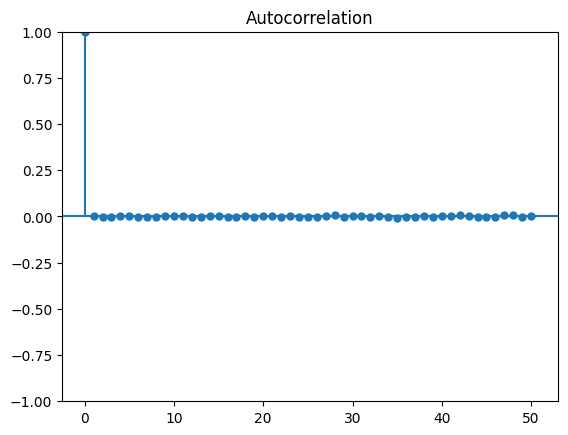

In [23]:
_ = plot_acf(best_model.resid, alpha = 0.05)

Sample ACF inside the bounds $\Rightarrow$ the residuals are iid noise.

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import jarque_bera

In [ ]:
acorr_ljungbox(best_model.resid)

In [ ]:
qqplot(best_model.resid)

In [ ]:
jarque_bera(best_model.resid)

## Forecasting

In [25]:
trend_coefficient = trend["1756-1-2"] -  trend["1756-1-1"]
seasonal = seas_decompose_4_years.seasonal
def forecast_in(start, end):
	period = 365 * 4 + 1
	forecasts = best_model.get_prediction(start = start, end = end-1).summary_frame()
	forecasts['seasonal']  = np.tile(seasonal[start%period : start%period + period].to_numpy(), int((end - start) / period) + 1 )[0 : end - start]
	forecasts['trend'] = trend_const + trend_coefficient * np.arange(start, end)
	forecasts['stationary'] = forecasts['mean']
	forecasts['mean'] += forecasts['seasonal'] + forecasts['trend']
	forecasts['mean_ci_lower'] += forecasts['seasonal'] + forecasts['trend']
	forecasts['mean_ci_upper'] += forecasts['seasonal'] + forecasts['trend']
	return forecasts

def forecast_out(n):
	period = 365 * 4 + 1
	forecasts = best_model.get_forecast(n).summary_frame()
	start = len(data)
	end = start + n
	forecasts['seasonal']  = np.tile(seasonal[start%period : start%period + period].to_numpy(), int((end - start) / period) + 1 )[0 : end - start]
	forecasts['trend'] = trend_const + trend_coefficient * np.arange(start, end)
	forecasts['stationary'] = forecasts['mean']
	forecasts['mean'] += forecasts['seasonal'] + forecasts['trend']
	forecasts['mean_ci_lower'] += forecasts['seasonal'] + forecasts['trend']
	forecasts['mean_ci_upper'] += forecasts['seasonal'] + forecasts['trend']
	return forecasts

In [26]:
forecasts = forecast_out(1000)

C:\Users\ollob\AppData\Local\Temp\ipykernel_21140\128039779.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


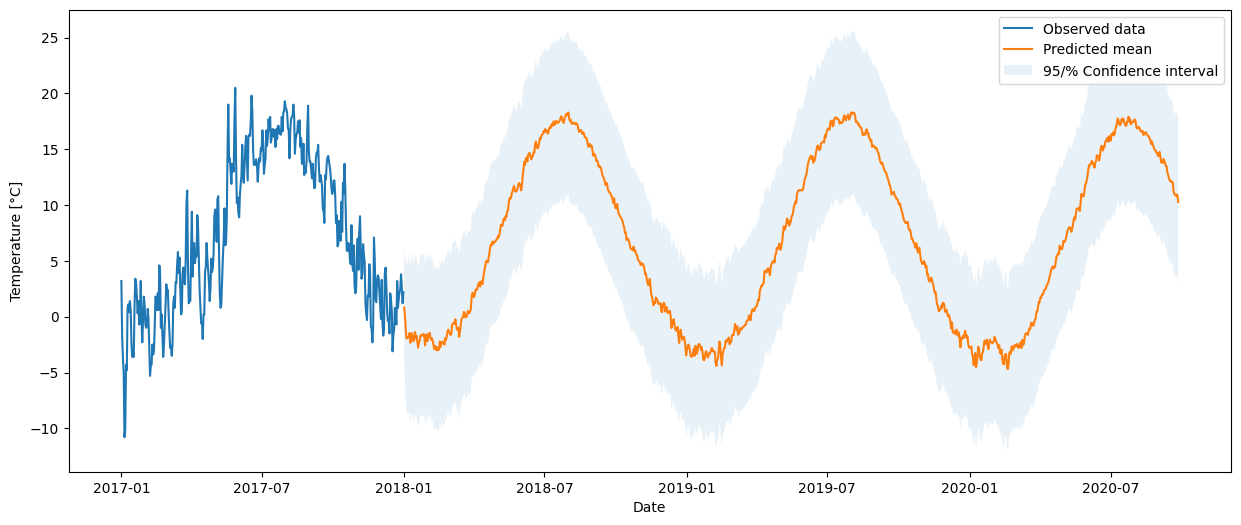

In [30]:
fig = plt.figure(figsize=(15, 6))
plt.plot(data.tail(365).index,data.tail(365)["Temperature"])
plt.plot(forecasts.index, forecasts['mean'])
plt.fill_between(forecasts.index, forecasts['mean_ci_lower'],forecasts['mean_ci_upper'], alpha = 0.1)
plt.legend(['Observed data','Predicted mean', '95/% Confidence interval'])
plt.xlabel('Date')
plt.ylabel('Temperature [°C]')
plt.savefig("A_forecasting")
fig.show()